In [164]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from scipy.constants import N_A
from scipy import linalg
import math, cmath
from sympy import *


In [165]:
Target_cell_number = 2e5
well_size = 150e-6
t_end = 60*60*10
t = np.geomspace(1e-8, t_end, 1000)
tspan = [1e-8, t_end]
z0 = [0, 0]
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)



In [166]:
def model_S_monospecific(t, z, Ainit, rtot, kon, k2, koff):
     k = Ainit*kon
     Atot = well_size*N_A*Ainit/Target_cell_number
     A0 = Atot - z[0] - z[1] 
     Ag = rtot - z[0] - 2*z[1]

     dA10 = 2*(k*Ag*A0/Atot) - koff*z[0] - (k2*Ag*z[0]) + 2*koff*z[1]
     dA11 = (k2*Ag*z[0]) - 2*koff*z[1]

     return [dA10, dA11]

def model_S_dimensionless(t, z, alpha1, alpha2, beta):

     A0 = beta - z[0] - z[1] 
     Ag = 1 - z[0] - 2*z[1]

     dA10 = 2*(alpha1*Ag*A0) - z[0] - (alpha2*Ag*z[0]) + 2*z[1]
     dA11 = (alpha2*Ag*z[0]) - 2*z[1]

     return [dA10, dA11]



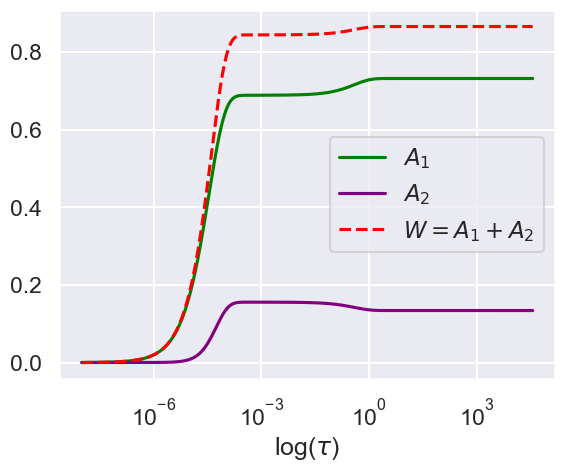

In [167]:
sns.set_theme()
sns.set_context('talk')
z = solve_ivp(model_S_dimensionless, tspan, z0, method='Radau', t_eval=t, args = (1, 1e4, 1e4))
A1 = z.y[0]
A2 = z.y[1]
plt.plot(t, A1, c='green', label=r'$A_1$')
plt.plot(t, A2, c='purple', label=r'$A_2$')
plt.plot(t, A1 + A2, c='red', label=r'$W=A_1+A_2$', linestyle='dashed')
plt.xscale('log')
plt.legend(loc='best')
plt.xlabel(r'log($\tau$)')
plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/sim_beta_1e4.png')

In [168]:
sigma = well_size*N_A/Target_cell_number

def A1_steady_state(x, Ainit, k1, koff, k2, rtot):
    k1 = k1/sigma
    Atot = well_size*N_A*Ainit/Target_cell_number
    express = 2*k1*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x))))*(Atot - x - (k2*x*(rtot-x)/(2*(koff + k2*x)))) -koff*x - k2*x*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x)))) +2*koff*(k2*x*(rtot-x)/(2*(koff + k2*x)))

    return express

def A2_steady_state(x, k2, koff, rtot):
    express = k2*x*(rtot-x)/(2*(koff + k2*x))

    return express

def A1_steady_state_dimensionless(x, Ainit, rtot, alpha1, alpha2):
    Atot = sigma*Ainit
    beta = Atot/rtot
    f0 = 2*alpha1*beta
    f1 = alpha1*(2*beta*alpha2 - 2 - 2*alpha2 - 2*beta) -1
    f2 = alpha1*(2 - 2*beta*alpha2) - 2*alpha2
    f3 = alpha1*alpha2 - (alpha2**2)

    return f3*(x**3) + f2*(x**2) + f1*x + f0

def A2_steady_state_dimensionless(A1, alpha2):

    return(alpha2*A1*(1-A1))/(2*(1 + alpha2*A1))

"""
def A1_steady_state(x, Ainit, k1, koff, k2, rtot):
    k1 = k1/sigma
    Atot = well_size*N_A*Ainit/Target_cell_number
    express = 2*k1*((rtot*Atot -rtot*x - Atot*x + (x**2))*((2*(koff + k2*x))**2) + 6*x*(k2*x*(rtot-x)*(koff + k2*x)) - 
                    4*Atot*k2*x*(rtot-x)*(koff +k2*x) + 2*((k2*x*(rtot-x))**2)) -koff*x* ((2*(koff + k2*x))**2) -k2*x*((rtot-x)*((2*(koff + k2*x))**2) 
                    - 4*k2*x*(rtot-x)*(koff + k2*x)) + 4*koff*k2*x*(rtot-x)*(koff + k2*x)
    
    return express
"""


'\ndef A1_steady_state(x, Ainit, k1, koff, k2, rtot):\n    k1 = k1/sigma\n    Atot = well_size*N_A*Ainit/Target_cell_number\n    express = 2*k1*((rtot*Atot -rtot*x - Atot*x + (x**2))*((2*(koff + k2*x))**2) + 6*x*(k2*x*(rtot-x)*(koff + k2*x)) - \n                    4*Atot*k2*x*(rtot-x)*(koff +k2*x) + 2*((k2*x*(rtot-x))**2)) -koff*x* ((2*(koff + k2*x))**2) -k2*x*((rtot-x)*((2*(koff + k2*x))**2) \n                    - 4*k2*x*(rtot-x)*(koff + k2*x)) + 4*koff*k2*x*(rtot-x)*(koff + k2*x)\n    \n    return express\n'

In [169]:
A0s = np.geomspace(1e-12, 1e-5, 1000)

A1_st_sim = np.zeros_like(A0s)
A1_st_root = np.zeros_like(A0s)
A2_st_sim = np.zeros_like(A0s)
A2_st_root = np.zeros_like(A0s)

D = 1e-14
k2 = 4*D/tumour_cell_surface_area
rtot = 1e6
r_ab = 1.25e-8
kon = 1e5
koff = 1e-4
alpha1 = kon*rtot/(koff*sigma)
alpha2 = k2*rtot/koff
"""
reaction_volume = (2*math.pi*(r_ab**3))/3
target_effective_conc =(rtot)*(tumour_cell_surface_area)*(1/N_A)/(reaction_volume)
k2 = target_effective_conc*kon
alpha2 = k2/koff
"""
for i, Ainit in enumerate(A0s):

    A1_st_root[i] = fsolve(A1_steady_state_dimensionless, [1], args=(Ainit, rtot, alpha1, alpha2))
    A2_st_root[i] = A2_steady_state_dimensionless(A1_st_root[i], alpha2)
    """
    A1_st_root[i] = fsolve(A1_steady_state, [0], args=(Ainit, 1e5, 1e-2, k2, 1e7))
    A2_st_root[i] = A2_steady_state(A1_st_root[i], k2, 1e-2, 1e7)
    z = solve_ivp(model_S_monospecific, tspan, z0, method='Radau', t_eval=t, args=(Ainit, 1e7, 1e5, k2, 1e-2))
    A1 = z.y[0]
    A2 = z.y[1]
    A1_st_sim[i] = A1[-1]
    A2_st_sim[i] = A2[-1]
    """


In [170]:
r_ab = 1.25e-8
reaction_volume = ((2*math.pi*(r_ab**3))/3)*(1000)
reaction_area = math.pi*(r_ab**2)
(1e4*reaction_area/tumour_cell_surface_area)*(1/N_A)*(1/reaction_volume)


2.477653131918024e-06

In [171]:
reaction_volume = (2*math.pi*(r_ab**3))/3
reaction_area = math.pi*(r_ab**2)
target_effective_conc =(rtot)*(reaction_area/tumour_cell_surface_area)*(1/N_A)/(reaction_volume)
target_effective_conc1 =(rtot)*(tumour_cell_surface_area)*(1/N_A)/(reaction_volume)
print(target_effective_conc, target_effective_conc1)

0.24776531319180237 0.00032647526491891564


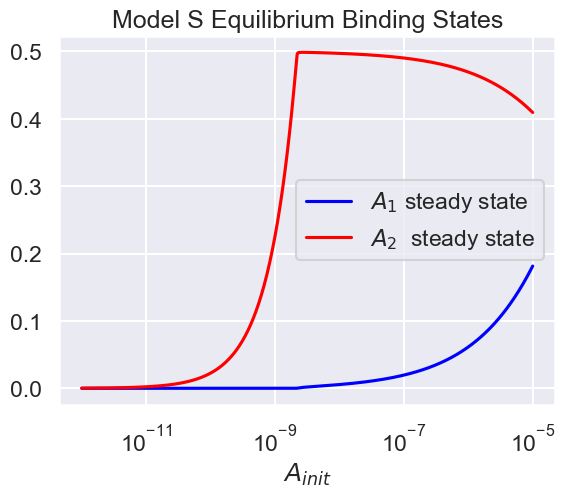

In [172]:
sns.set_theme()
sns.set_context('talk')
plt.plot(A0s, A1_st_root, label = r'$A_1$' + ' steady state', color='blue')
#plt.plot(A0s, A1_st_root, label = 'A1 calculated root')
plt.plot(A0s, A2_st_root, label = r'$A_2$ ' + ' steady state', color='red')
#plt.plot(A0s, A2_st_root, label = 'A2 calculated root')

plt.title('Model S Equilibrium Binding States')
plt.xscale('log')
plt.legend(loc='best')
plt.xlabel(r'$A_{init}$')
plt.show()

0.2214052089565129


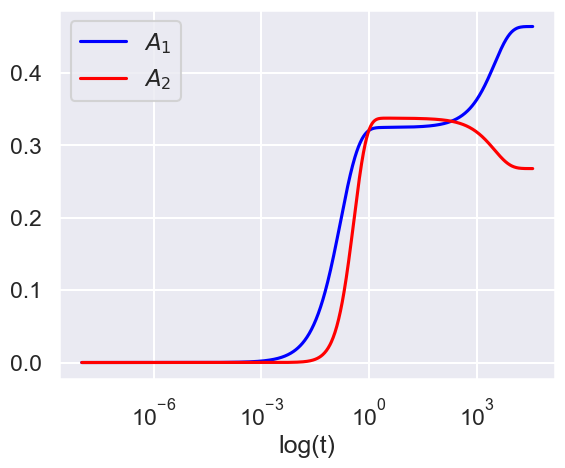

In [173]:
print((1e5/sigma)*1e5/1e-4)
z = solve_ivp(model_S_monospecific, tspan, z0, method='Radau', t_eval=t, args=(1e-5, 1e5, 1e5, k2, 1e-4))
plt.plot(t, z.y[0]/1e5, label=r'$A_1$', c='blue')
plt.plot(t, z.y[1]/1e5, label = r'$A_2$', c='red')
plt.legend(loc='best')
plt.xlabel('log(t)')
plt.xscale('log')
plt.show()

In [174]:
print(1e-5*sigma/1e5)

45166.0557


In [175]:
def A2_nullcline1(A2, alpha2):
    a = 1
    b = 2*A2 -1 
    c = (2/alpha2)
    express = (-b + np.sqrt((b)**2 - 4*a*c))/(2*a)

    return express

def A2_nullcline2(A2, alpha2):
    a = 1
    b = 2*A2 -1 
    c = (2/alpha2)
    express = (-b - np.sqrt((b)**2 - 4*a*c))/(2*a)

    return express

def A1_nullcline1(A2, alpha1, alpha2, beta):
    a = (2*alpha1 + alpha2)
    b = (2*alpha1)*(3*A2 - beta - 1)  -1 -alpha2*(1+2*A2)
    c = 2*alpha1*(beta*(1- 2*A2) - A2 + 2*((A2)**2)) + 2*A2
    express = (-b - np.sqrt((b)**2 - 4*a*c))/(2*a)

    return express

def A1_nullcline2(A2, alpha1, alpha2, beta):
    a = (2*alpha1 + alpha2)
    b = (2*alpha1)*(3*A2 - beta - 1)  -1 -alpha2*(1+2*A2)
    c = 2*alpha1*(beta*(1- 2*A2) - A2 + 2*((A2)**2)) + 2*A2
    express = (-b + np.sqrt((b)**2 - 4*a*c))/(2*a)

    return express



In [176]:
def A2_nullcline(x, alpha2):

    return (alpha2*x*(1-x))/(2*(1+ x*alpha2))

def A1_nullcline1(A1, alpha1, alpha2, beta):
    a = (4*alpha1)
    b = (2*alpha1)*(3*A1 - 2*beta - 1)  + 2 + 2*alpha2*A1
    c = 2*alpha1*(beta - A1 - A1*beta + ((A1)**2)) - A1 -alpha2*A1*(1-A1)
    express = (-b - np.sqrt((b)**2 - 4*a*c))/(2*a)

    return express

def A1_nullcline2(A1, alpha1, alpha2, beta):
    a = (4*alpha1)
    b = (2*alpha1)*(3*A1 - 2*beta - 1)  + 2 + 2*alpha2*A1
    c = 2*alpha1*(beta - A1 - A1*beta + ((A1)**2)) - A1 -alpha2*A1*(1-A1)
    express = (-b + np.sqrt((b)**2 - 4*a*c))/(2*a)

    return express

0.2214052089565129
4973.5919716217295
451.66055700000004


/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_15510/4036392180.py:9: RuntimeWarning: invalid value encountered in sqrt
  express = (-b - np.sqrt((b)**2 - 4*a*c))/(2*a)
/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_15510/4036392180.py:17: RuntimeWarning: invalid value encountered in sqrt
  express = (-b + np.sqrt((b)**2 - 4*a*c))/(2*a)


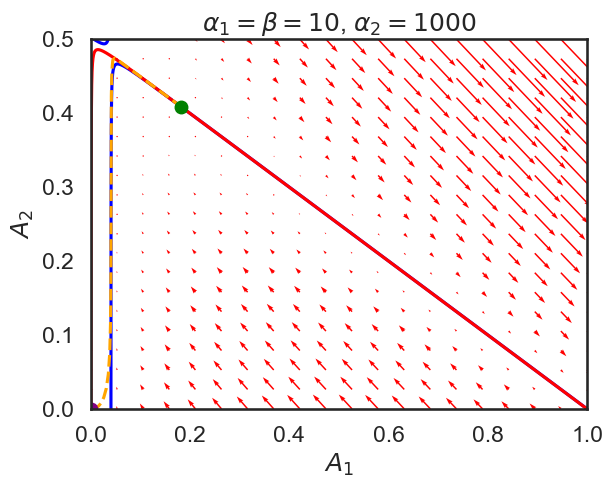

In [177]:
sns.set_theme(style = "white")
sns.set_context("talk")

kon = 1e5
rtot = 1e5
x1 = np.linspace(0, 1, 50000)
x2 = np.linspace(0, 1/2, 500)
D = 1e-15
k2 = 4*D/tumour_cell_surface_area
koff = 1e-4
Ainit = 1e-7
Atot = well_size*N_A*Ainit/Target_cell_number
t_end = 60*60*10*1000000000
t = np.geomspace(1e-10, t_end, 150)
tspan = [1e-10, t_end]

sigma = well_size*N_A/Target_cell_number
alpha1 = kon*rtot/(sigma*koff)
print(alpha1)
alpha2 = k2*rtot/koff
print(alpha2)
beta = Atot/rtot
print(beta)
#alpha1 = 100
#alpha2 = 10
#beta = 100

t1 = 0

z = solve_ivp(model_S_dimensionless, tspan, z0, method='Radau', t_eval=t, args=(alpha1, alpha2, beta))
y1 = np.linspace(0, 1, 20)
y2 = np.linspace(0, 0.5, 20)

Y1, Y2 = np.meshgrid(y1, y2)

A1, A2 = np.zeros(Y1.shape), np.zeros(Y2.shape)

Ni, Nj = Y1.shape

for i in range(Ni):
    for j in range(Nj):
        x = Y1[i, j]
        y = Y2[i, j]
        yprime = model_S_dimensionless(t1, [x, y], alpha1, alpha2, beta)
        A1[i, j] = yprime[0]
        A2[i, j] = yprime[1]

plt.plot(x1, A1_nullcline1(x1, alpha1, alpha2, beta),  c='blue', label='A1 nullcline')
plt.plot(x1, A1_nullcline2(x1, alpha1, alpha2, beta), c= 'blue')#, label='null 3')
plt.plot(x1, A2_nullcline(x1, alpha2),  c='red', label='A1 nullcline')
Q = plt.quiver(Y1, Y2, A1, A2, color='red')
z1 = z.y[0]
z2 = z.y[1]
plt.plot(z1, z2, '--', label='trajectory', c='orange')
plt.plot([z1[0]], [z2[0]], 'o', c = 'purple',label='initial condition')
plt.plot([z1[-1]], [z2[-1]], 'o', c='green', label='equilibrium')

#f = A2_steady_state(x1, alpha2)
#g = A2_alternative_null_minus(x2, alpha1, alpha2, beta)



#plt.legend(loc='best')


plt.xlim(0, 1)
plt.ylim(0, 0.5)
plt.xlabel(r'$A_1$')
plt.title(r'$\alpha_1 = \beta = 10$' + r', $\alpha_2=1000$')
plt.ylabel(r'$A_2$')
#sns.despine()
plt.show()


In [178]:
A0s = np.geomspace(1e-12, 1e-5, 50)
alpha1s = np.geomspace(1e-3, 1e2, 50)
alpha2s = np.geomspace(1e2, 1e7, 50)
k1s = np.geomspace(1e4, 1e6, 50)
r_abs = np.linspace(1e-8, 5e-8, 50)
rtots = np.geomspace(1e4, 1e6, 50)
rtot = 1e5
kon = 1e5
koff = 1e-4
sigma = well_size*N_A/Target_cell_number

r_ab = 1.25e-8
r_cell = 8e-6
Target_cell_number = 2e5
reaction_volume = (2*math.pi/3)*(r_ab**3)
Ageff = (1/reaction_volume)*(rtot/N_A)*((4*math.pi*r_ab)**2)
assay_volume = 150e-6
D = 1e-14
#k2 = 4*D/tumour_cell_surface_area
alpha1 = kon*rtot/(sigma*koff)
#k2 = kon*Ageff
#alpha2 = k2/koff
k1 = 1e5

Y = np.zeros((len(alpha1s), len(alpha2s)))
Y1 = np.zeros((len(alpha1s), len(alpha2s)))

for i, alpha2 in enumerate(alpha2s):
    for j, Ainit in enumerate(A0s):
        

        A1 = fsolve(A1_steady_state_dimensionless, [1], args=(Ainit, rtot, alpha1, alpha2))
        Y[i, j] = A1
        Y1[i, j] = A2_st_root[i] = A2_steady_state_dimensionless(A1, alpha2)


[1.00000000e+02 1.26485522e+02 1.59985872e+02 2.02358965e+02
 2.55954792e+02 3.23745754e+02 4.09491506e+02 5.17947468e+02
 6.55128557e+02 8.28642773e+02 1.04811313e+03 1.32571137e+03
 1.67683294e+03 2.12095089e+03 2.68269580e+03 3.39322177e+03
 4.29193426e+03 5.42867544e+03 6.86648845e+03 8.68511374e+03
 1.09854114e+04 1.38949549e+04 1.75751062e+04 2.22299648e+04
 2.81176870e+04 3.55648031e+04 4.49843267e+04 5.68986603e+04
 7.19685673e+04 9.10298178e+04 1.15139540e+05 1.45634848e+05
 1.84206997e+05 2.32995181e+05 2.94705170e+05 3.72759372e+05
 4.71486636e+05 5.96362332e+05 7.54312006e+05 9.54095476e+05
 1.20679264e+06 1.52641797e+06 1.93069773e+06 2.44205309e+06
 3.08884360e+06 3.90693994e+06 4.94171336e+06 6.25055193e+06
 7.90604321e+06 1.00000000e+07]


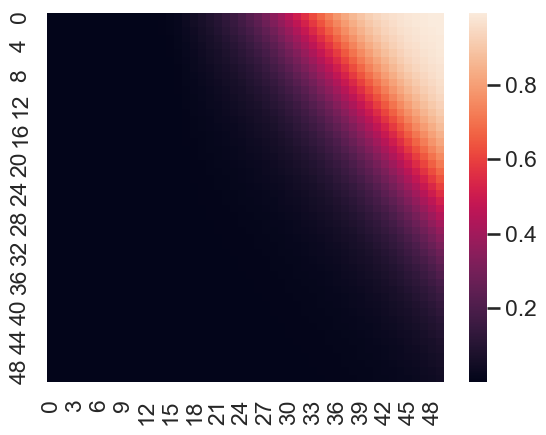

In [179]:
sns.heatmap(Y)
print(alpha2s)

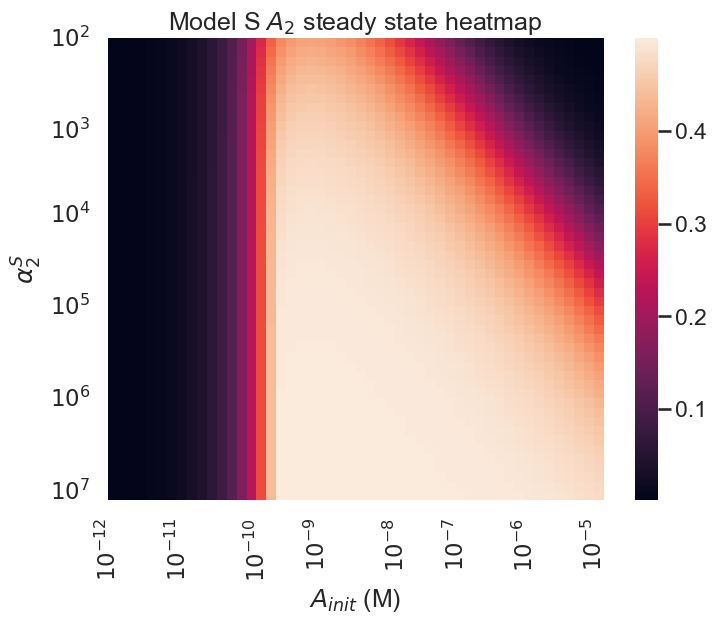

In [180]:

fig, ax = plt.subplots(figsize=(8, 6))
line = sns.heatmap(Y1, xticklabels=True, yticklabels=True, ax=ax) 
#ax = sns.heatmap(Y[0,:,:], xticklabels=True, yticklabels=True, ax=ax)
ax.set_xticks([0, 7, 15, 21, 29, 35, 42, 49])
ax.set_yticks([0, 10, 19, 29, 39, 49])
#ax.set_yticklabels([10, r'$10^2$', r'$10^3$', r'$10^4$', r'$10^5$'])
ax.set_yticklabels([r'$10^{2}$', r'$10^{3}$',r'$10^{4}$', r'$10^{5}$', r'$10^{6}$', r'$10^{7}$'])
ax.set_xticklabels([r'$10^{-12}$', r'$10^{-11}$', r'$10^{-10}$', r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$'])
ax.set_xlabel(r'$A_{init}$' + ' (M)')
ax.set_ylabel(r'$\alpha_2^S$')
ax.set_title('Model S ' + r'$A_2$' + ' steady state heatmap')
plt.show()